# Introduction
This python notebook will be used for testing out the NZN parameter sets

## Importing functions and parameter sets

In [1]:
from besos.parameters import wwr, RangeParameter, FieldSelector, FilterSelector, GenericSelector, Parameter, expand_plist
from besos.parameters import RangeParameter, CategoryParameter, expand_plist

from besos import eppy_funcs as ef
import besos.sampling as sampling
from besos.evaluator import EvaluatorEP
from besos.problem import EPProblem

import copy
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import matplotlib.pyplot as plt

In [2]:
import os
import sys

#importing a pre-existing parameter set database
nzn_pathway='./parameter_set'
sys.path.append(nzn_pathway)

from architectural_parameters import architectural_parameters
# from comfort_parameters import comfort_parameters
from envelope_parameters import envelope_parameters
# from lighting_parameters import lighting_parameters
# from loads_parameters import loads_parameters
# from plant_parameters import heating_plant_parameters
# from plant_parameters import cooling_plant_parameters
# from renewable_parameters import renewable_parameters
# from system_parameters import system_parameters
# from system_parameters import FCU_parameters
# from system_parameters import VAV_parameters
# from system_parameters import CB_parameters

In [3]:
parameters=[]
defaults={}
inputs_metadata=[]

parameter_sets=[architectural_parameters,envelope_parameters]

for i in parameter_sets:
    parameters.extend(i()[0])
    defaults.update(i()[1])
    inputs_metadata.extend(i()[2])

/home/user/.local/lib/python3.7/site-packages/besos/parameters.py:425: FutureWarning: Use value_descriptors instead of value_descriptor.
  FutureWarning("Use value_descriptors instead of value_descriptor.")


In [4]:
# inputs_metadata

In [5]:
import NZN_output_set
from NZN_output_set import fuel_use
from NZN_output_set import end_use_breakdown
from NZN_output_set import metrics

In [6]:
outputs, outputs_metadata = fuel_use()
outputs1, outputs_metadata1 = end_use_breakdown()
outputs2, outputs_metadata2 = metrics()

outputs = outputs+outputs1+outputs2
outputs_metadata = outputs_metadata+outputs_metadata1+outputs_metadata2

In [7]:
len(outputs_metadata)

24

In [8]:
# Drop any metadata associated with dropped outputs (reference Sampling notebook to confirm which outputs to drop - they must match)

def remove_output_metadata(removed_output_metadata_list, output_metadata_list):
    for label in removed_output_metadata_list:
        for metadata in output_metadata_list:
            if metadata['Label'] == ("{} (ekWh/m2)".format(label)):
                print(label)
                output_metadata_list.remove(metadata)
            
    return output_metadata_list

Manually edit 'removed_output_metadata_list' to include all ouput metadata that should not be included.

In [9]:
removed_output_metadata_list = ['Gas:Facility','Heating:Electricity','Heating:Gas','Cooling:Electricity','ExteriorLights:Electricity', 
                        'InteriorEquipment:Gas', 'ExteriorEquipment:Electricity', 'ExteriorEquipment:Gas', 
                        'Fans:Electricity', 'Pumps:Electricity', 'HeatRejection:Electricity', 'Humidifier:Electricity', 'Humidifier:Gas', 
                        'WaterSystems:Electricity', 'WaterSystems:Gas', 'TED', 'TEU'] # Had to remove TEU on this archetype or it wouldnt run
outputs_metadata = remove_output_metadata(removed_output_metadata_list, outputs_metadata)

Gas:Facility
Heating:Electricity
Heating:Gas
Cooling:Electricity
ExteriorLights:Electricity
InteriorEquipment:Gas
ExteriorEquipment:Electricity
ExteriorEquipment:Gas
Fans:Electricity
Pumps:Electricity
HeatRejection:Electricity
Humidifier:Electricity
Humidifier:Gas
WaterSystems:Electricity
WaterSystems:Gas
TED
TEU


In [10]:
len(outputs_metadata)

7

In [11]:
# Import the pickled inputs and results from Sampling Notebook
inputs = pd.read_pickle('overall_inputs.p')
results_EUI = pd.read_pickle('overall_results.p')

# Building Specific Metadata

In [12]:
default_building = ef.get_building('NZN_Retail_Stand_Alone_Default.idf')

In [13]:
# Get approximate floor area of building
def get_floor_area(model):
    prev_area = 0
    for surface in model.idfobjects['BUILDINGSURFACE:DETAILED']:
        if surface['Surface_Type'] == 'Floor':
            area = surface.area
            total_area = area + prev_area
            prev_area = total_area
    est_floor_area = (str(round(total_area)) + ' m2')
    return(est_floor_area)

est_floor_area = get_floor_area(default_building)
print(est_floor_area)

2294.0 m2


In [14]:
print(default_building.idfobjects['BUILDING'][0].Name)   # Use this to double check building type against model
print(default_building.idfobjects['SITE:LOCATION'][0].Name)  # Use this to double check building location against model

NZN_Retail_Stand_Alone
Victoria Int'l


In [15]:
# Reference picture of model
from IPython.display import Image
photo = Image("thumbnail.png")
# photo

Enter in building description here:

In [16]:
building_description = """"This typical stand alone retail building is one story with a story height 
of 6.1 m. It has been separated into 5 thermal zones, a front entry way, a core retail space, a point 
of sale area, a front retail space, and a back area (likely for storage). Each thermal zone has its 
own spacetype. There are 16 skylights in the core retail space. There are no doors, but there is a 
fixed window in the shape of a main door in the front entry area."""

Define building metadata in dictionary below. Fields can all be entered manually if desired.

In [17]:
model_attributes = {
    "Building Type" : "Retail Stand Alone",
    "Location" : "Victoria, BC",
    "Estimated Floor Area" : est_floor_area,
    "Photo" : photo,
    "Description": building_description
    }

In [18]:
# model_attributes

# Surrogate Model
A surrogate model will be used to speed up the analysis process. After the initial sampling, the surrogate will be used to do a massive re-sampling to feed into our statistics.

The general steps to create a surrogate model are:
- Create the general architecture
- Identify hyper-parameters
- Normalize the inputs
- Normalize the outputs
- Split to training & testing set
- Train the ML model
- Validate

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, LeakyReLU


Couldn't import dot_parser, loading of dot files will not be possible.


## One Hot Encoding
We need to convert our categorical values in one-hot encoded columns for non-ordinal ML training.

In [20]:
inputs_onehot=pd.get_dummies(inputs)
inputs_onehot

North Window to Wall Ratio (%)  East Window to Wall Ratio (%)  \
0                         0.112199                       0.492051   
1                         0.950713                       0.123351   
2                         0.706142                       0.626858   
3                         0.983063                       0.558892   
4                         0.619865                       0.848093   
5                         0.454905                       0.305314   
6                         0.782938                       0.243525   
7                         0.420145                       0.132954   
8                         0.288610                       0.292312   
9                         0.757396                       0.705049   
10                        0.156005                       0.229867   
11                        0.185374                       0.883255   
12                        0.665973                       0.334440   
13                        0.586696                       0.817069   
14                        0.332814                       0.057334   
15                        0.381030                       0.733519   
16                        0.302681                       0.690546   
17                        0.884425                       0.955031   
18                        0.914620                       0.167366   
19                        0.823298                       0.571386   
20                        0.070089                       0.511431   
21                        0.837172                       0.425980   
22                        0.500031                       0.070410   
23                        0.019603                       0.899764   
24                        0.553129                       0.773061   
25                        0.652962                       0.644221   
26                        0.481005                       0.962232   
27                        0.215423                       0.024353   
28                        0.243759                       0.385923   
29                        0.058731                       0.453177   

    South Window to Wall Ratio (%)  West Window to Wall Ratio (%)  \
0                         0.681327                       0.416346   
1                         0.339723                       0.587781   
2                         0.645683                       0.741475   
3                         0.962892                       0.654193   
4                         0.704697                       0.189619   
5                         0.445605                       0.498274   
6                         0.782372                       0.948249   
7                         0.891097                       0.818845   
8                         0.939647                       0.864077   
9                         0.124765                       0.828959   
10                        0.904300                       0.392316   
11                        0.214309                       0.557176   
12                        0.069007                       0.465248   
13                        0.027217                       0.004019   
14                        0.381114                       0.662045   
15                        0.056004                       0.979096   
16                        0.608378                       0.148742   
17                        0.248723                       0.779559   
18                        0.519490                       0.222245   
19                        0.291211                       0.908525   
20                        0.569062                       0.294391   
21                        0.813712                       0.104209   
22                        0.733178                       0.063027   
23                        0.326171                       0.359049   
24                        0.193190                       0.075274   
25                        0.473635                       0.697973   
2

## Train-Test Split
We'll do 80/20 train/test split here

In [21]:
train_in, test_in, train_out, test_out = train_test_split(inputs_onehot, results_EUI, test_size=0.2)

## Normalization of inputs

To ensure an equal weighting of inputs and outputs in the backpropagation algorithm fitting the neural network, we have to normalize the input values.   
Different options for normalization exist.  
Here we bring all features (input variables) to have zero mean and a standarddeviation of 1.  
Note that we fit the normalizer on training data only.

In [22]:
scaler_in = StandardScaler()
NN_inputs = scaler_in.fit_transform(X=train_in)
NN_inputs_test=scaler_in.transform(X=test_in)

scaler_out = StandardScaler()
NN_outputs = scaler_out.fit_transform(X=train_out+0.00001)
NN_outputs_test=scaler_out.transform(X=test_out+0.00001)

In [23]:
# NN_outputs

## Build the Model
Using the keras functional API, we will build a relatively simple deep neural network

In [24]:
#This matches the number of parameter inputs we have to enter as the input layer into the NN
num_inputs = len(inputs_onehot.columns)
print(f'Number of inputs: {num_inputs}')
#This matches the number of model outputs we have to enter as the output layer into the NN
num_outputs = len(results_EUI.columns)
print(f'Number of inputs: {num_outputs}')

Number of inputs: 19
Number of inputs: 7


In [25]:
results_EUI

Electricity:Facility  DistrictHeating:Facility  DistrictCooling:Facility  \
0              46.109886                 49.783999                 11.120736   
1              47.539326                 44.737896                 35.105899   
2              48.616116                 90.357849                 19.586629   
3              48.433577                212.107848                 12.714323   
4              48.139453                147.042355                 20.807057   
5              46.882582                135.090347                 20.338484   
6              46.187194                 76.017226                 29.221254   
7              45.666617                166.079706                 10.721547   
8              46.486417                122.495580                 12.336788   
9              46.789623                 58.553492                 25.056315   
10             49.115277                338.804772                 19.781465   
11             47.245600                 12.899133                 24.000859   
12             52.332868                125.113549                  6.341857   
13             51.835922                 49.609549                 12.091161   
14             46.307614                209.591679                 12.067579   
15             46.783232                 52.826983                 26.685941   
16             51.593987                 88.821134                 18.059172   
17             48.370308                 70.567317                 34.870764   
18             47.759341                187.113827                  9.060654   
19             46.135123                184.430149                 26.097378   
20             46.218144                223.362083                 16.997711   
21             53.657073                160.428743                 27.536509   
22             53.065296                159.528112                 14.593636   
23             48.064984                250.907627                 26.171210   
24             52.734722                 43.771827                 14.103429   
25             46.152290                 39.937005                 17.699747   
26             48.211687                133.458666                 14.131173   
27             50.920982                217.467509                 12.186336   
28             46.687977                127.617499                  7.164784   
29             48.801357                 90.067177                 10.575166   

    Heating:DistrictHeating  Cooling:DistrictCooling  \
0                 49.783999                11.120736   
1                 44.737896                35.105899   
2                 90.357849                19.586629   
3                212.107848                12.714323   
4                147.042355                20.807057   
5                135.090347                20.338484   
6                 76.017226                29.221254   
7                166.079706                10.721547   
8                122.495580                12.336788   
9                 58.553492                25.056315   
10               338.804772                19.781465   
11                12.899133                24.000859   
12               125.113549                 6.341857   
13                49.609549                12.091161   
14               209.591679                12.067579   
15                52.826983                26.685941   
16                88.821134                18.059172   
17                70.567317                34.870764   
18               187.113827                 9.060654   
19               184.430149                26.097378   
20               223.362083                16.997711   
21               160.428743                27.536509   
22               159.528112                14.593636   
23               250.907627                26.171210   
24                43.771827                14.103429   
25                39.937005                17.699747   
26         

In [26]:
#Create a 4-layer model, with 2 middle layers both with nodes that are 16*the number of inputs
#The hidden layers are activated with ReLU function.
# Since we are performing regression we do not want an activation for the output. 
#The output has been normalized to 0 +/- 1 std, and a ReLU activation function only returns positive numbers.
#We will use an L2 regularizer to help prevent overfitting. For now we will use the default alpha 0.01.

input_layer = keras.Input(shape=(num_inputs,))

#first hidden layer
dense_1 = layers.Dense(units=num_inputs*5, kernel_regularizer='l1_l2')(input_layer)
activation_1=layers.LeakyReLU()(dense_1)
#second hidden layer
dense_2 = layers.Dense(units=num_inputs*5, kernel_regularizer='l1_l2')(activation_1)
activation_2=layers.LeakyReLU()(dense_2)
#third hidden layer
dense_3 = layers.Dense(units=num_inputs*5, kernel_regularizer='l1_l2')(activation_2)
activation_3=layers.LeakyReLU()(dense_3)


#output layer
output_layer = layers.Dense(units=num_outputs)(activation_3)

model=models.Model(inputs=input_layer,outputs=output_layer)

In [27]:
print(model.summary())
# plot_model(model)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 19)]              0         
_________________________________________________________________
dense (Dense)                (None, 95)                1900      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 95)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 95)                9120      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 95)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 95)                9120      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 95)               

## Hyper-parameters

Before we start fitting the NN model we define the set of hyperparameters we want to analyse in our cross-validation to optimize the model.  
Here, we select the number of layers of the network as well as the regularization parameter alpha as parameter value.  
A larger number of layers and a lower value of the regularizer lead to higher variance of the network.  
This may lead to overfitting.  
The best selection may be found using an optimizer like Bayesian Optimization.  
In this example we use a simple grid search.

## Training

Here we will compile and train the model.

In [28]:
loss = 'mean_squared_error'
optimizer = 'adam'
metrics=['mae', 'mse']

model.compile(loss=loss,optimizer=optimizer,metrics=metrics)

In [29]:
history=model.fit( x=NN_inputs, y=NN_outputs, batch_size = 256,epochs=1000)
test_scores = model.evaluate(NN_inputs_test, NN_outputs_test, verbose=2)
print("Test MAE:", test_scores[0])
print("Test MSE:", test_scores[1])

Epoch 1/1000
1/1 [==============================] - 0s 1ms/step - loss: 21.3863 - mae: 0.8077 - mse: 1.0430
Epoch 2/1000
1/1 [==============================] - 0s 1ms/step - loss: 21.1364 - mae: 0.7926 - mse: 1.0118
Epoch 3/1000
1/1 [==============================] - 0s 1ms/step - loss: 20.8898 - mae: 0.7786 - mse: 0.9832
Epoch 4/1000
1/1 [==============================] - 0s 892us/step - loss: 20.6467 - mae: 0.7659 - mse: 0.9572
Epoch 5/1000
1/1 [==============================] - 0s 932us/step - loss: 20.4070 - mae: 0.7543 - mse: 0.9337
Epoch 6/1000
1/1 [==============================] - 0s 857us/step - loss: 20.1707 - mae: 0.7436 - mse: 0.9125
Epoch 7/1000
1/1 [==============================] - 0s 935us/step - loss: 19.9369 - mae: 0.7336 - mse: 0.8929
Epoch 8/1000
1/1 [==============================] - 0s 974us/step - loss: 19.7056 - mae: 0.7242 - mse: 0.8749
Epoch 9/1000
1/1 [==============================] - 0s 944us/step - loss: 19.4767 - mae: 0.7154 - mse: 0.8583
Epoch 10/1000
1/

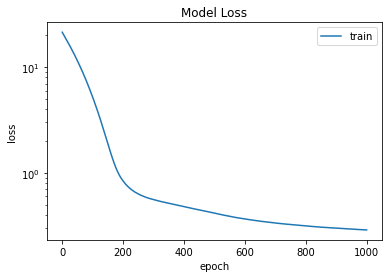

In [30]:
fig = plt.figure()
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

## Evaluate test set
Evaluate the test set using the NN and the actual values

In [31]:
test_eval=model(NN_inputs_test,training=False)
test_eval=scaler_out.inverse_transform(test_eval)
test_eval_df=pd.DataFrame(test_eval,columns=results_EUI.columns)

In [32]:
# test_eval_df
# test_out

## Visually Compare the test dataset

In [33]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

In [35]:
mask = test_eval_df.isnull().values.sum(axis=1)==1
print(mask.sum())

0


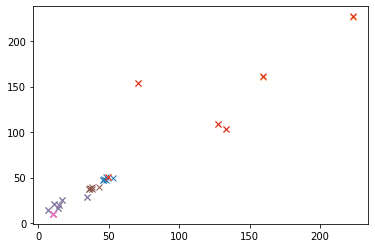

In [36]:
_=[plt.plot(test_out.iloc[:,i], test_eval_df.iloc[:,i],'x') for i in range(num_outputs)]
print()

[ 3.30531848e-01  5.82934235e-01  3.59691052e-01  5.76303882e-01
  3.54524080e-01  3.22605871e-01 -4.95020014e+19]



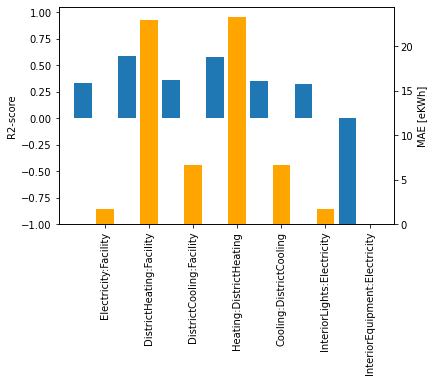

In [37]:
outputs=results_EUI.columns

plt.bar(range(0,len(outputs)*2,2),r2_score(test_out.values[:,:], test_eval_df.values[:,:], multioutput='raw_values'))
plt.ylim([-1,1.05])
ax = plt.gca()
ax2=ax.twinx()

ax2.bar(range(1,len(outputs)*2,2),
        mean_absolute_error(test_out.values[:,:], test_eval_df.values[:,:], multioutput='raw_values'),
       color='orange')

ax.set_xticks(range(1,len(outputs)*2,2))
_=ax.set_xticklabels(outputs, rotation=90)
ax.set_ylabel('R2-score')
ax2.set_ylabel('MAE [eKWh]')
plt.grid=False
print(r2_score(test_out.values[:,:], test_eval_df.values[:,:], multioutput='raw_values'))
print()

In [38]:
results_EUI.columns
end_uses=results_EUI.columns[2:-2]

This plotly chart is an interactive chart that will show the end-use breakdown in bar charts. It compares the results of a NN and the original E+ simulations.

In [39]:
# traces=[]
# buttons=[dict(label = "All",
#                  method = "update",
#                  args = [{"visible": True}])]

# for row in test_eval_df.index.to_list():
#     visibles=[False]*len(test_eval_df.index)
#     visibles[row]=True
    
#     traces.append(
#         go.Bar(
#             x = end_uses,
#             y = test_eval_df.iloc[row][end_uses],
#             name = (f"NN: {row}"),
#             yaxis="y2"
#         ))
    
#     buttons.append(
#     dict(label = str(row),
#                  method = "update",
#                  args = [{"visible": visibles}])
#     )
    
# for row in test_eval_df.index.to_list():
   
#     traces.append(
#         go.Bar(
#             x = end_uses,
#             y = test_out.iloc[row][end_uses],
#             name = (f"E+: {row}"),
#             yaxis="y2"
            
#         ))   
    
# for row in test_eval_df.index.to_list():
   
#     traces.append(
#         go.Table(
#             header=dict(
#                 values=test_in.columns,
#                 font=dict(size=10),
#                 align="left"
#             ),
#             cells=dict(
#                 values=test_in.iloc[row].tolist(),
#                 align = "left")
#         ))    

    
# updatemenus=[dict(active=-1,
#          buttons=buttons)]
    
# layout = dict(title="Dropdown",
#               showlegend=True,
#               xaxis=dict(title="Source"),
#               yaxis=dict(title="Number", range=(-5, test_eval_df[end_uses].max().max()*1.1)),
#               updatemenus=updatemenus,
#               height=600)

# fig = make_subplots(rows=2,cols=1,
#                    row_heights=[.3,.7])
                         
# fig.add_traces(traces)
# fig.update_layout(layout)
# fig.show()

We've noticed that the main parameters affected by this parameter set are the heating:gas, and humidifier:electricity parameters. Let's look at R2 plots for these two parameters

In [40]:
#Scatter subplots of NN vs E+ results

#for now we will do it quickly with express
import plotly.express as px


# traces=[]

# traces.append(
#     go.Scatter(x=test_eval_df['Heating:Gas'],
#               y=test_in['Heating:Gas']))

# variable='TEU'
# min_range=test_out[variable].min()-10
# max_range=test_out[variable].max()+10

# fig = px.scatter(x=test_eval_df[variable],y=test_out[variable])
# fig.update_layout(
#         yaxis=dict(range=[min_range,max_range]),
#         xaxis=dict(range=[min_range,max_range]),
#         xaxis_title='NN',
#         yaxis_title='E+',
#         height=500,
#         width=500)

# fig.add_shape(
#         # 1-1 Line
#         dict(
#             type="line",
#             x0=min_range,
#             y0=min_range,
#             x1=max_range,
#             y1=max_range,
#             line=dict(
#                 color="Red",
#                 width=1
#             )))
# fig.show()

In [41]:
# #Scatter subplots of NN vs E+ results

# #for now we will do it quickly with express
# import plotly.express as px


# # traces=[]

# # traces.append(
# #     go.Scatter(x=test_eval_df['Heating:Gas'],
# #               y=test_in['Heating:Gas']))

# variable='Cooling:Electricity'
# min_range=test_out[variable].min()-10
# max_range=test_out[variable].max()+10

# fig = px.scatter(x=test_eval_df[variable],y=test_out[variable])
# fig.update_layout(
#         yaxis=dict(range=[min_range,max_range]),
#         xaxis=dict(range=[min_range,max_range]),
#         xaxis_title='NN',
#         yaxis_title='E+',
#         height=500,
#         width=500)

# fig.add_shape(
#         # 1-1 Line
#         dict(
#             type="line",
#             x0=min_range,
#             y0=min_range,
#             x1=max_range,
#             y1=max_range,
#             line=dict(
#                 color="Red",
#                 width=1
#             )))
# fig.show()

# Store metadata

In [42]:
results_EUI.columns=['Electricity:Facility [ekWh/m2]', 'DistrictHeating:Facility [ekWh/m2]',
       'DistrictCooling:Facility [ekWh/m2]', 'Heating:DistrictHeating [ekWh/m2]',
       'Cooling:DistrictCooling [ekWh/m2]', 'InteriorLights:Electricity [ekWh/m2]',
       'InteriorEquipment:Electricity [ekWh/m2]'] # Had to remove TEU from this archetype because it wouldn't run

In [43]:
inputs_dataframe = inputs_onehot
inputs_index = inputs_onehot.columns
outputs_dataframe = results_EUI
outputs_index = results_EUI.columns
inputs_scaler = scaler_in
outputs_scaler = scaler_out

In [44]:
all_model_metadata = {"inputs_index": inputs_index,
                      "inputs_metadata": inputs_metadata,
                      "model_attributes": model_attributes,
                      "outputs_index": outputs_index,
                      "outputs_metadata": outputs_metadata,
                      "inputs_scaler": inputs_scaler,
                      "outputs_scaler": outputs_scaler,
                      "inputs_dataframe": inputs_dataframe,
                      "outputs_dataframe": outputs_dataframe}

In [45]:
import pickle
pickle.dump(all_model_metadata, open('model_pickle','wb'))

# Store model

In [46]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


# Tensorflow js model

In [47]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model,'model_new')

/usr/local/lib/python3.7/dist-packages/tensorflowjs/converters/keras_h5_conversion.py:123: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)


In [48]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)